In [1]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [4]:
data = pd.read_csv('./statistic_2022_12_07.csv').drop(['Unnamed: 0'], axis=1)
data['add_date'] = pd.to_datetime(data['add_date'])
data['tmp'] = data['is_touched']
data['is_touched'] = data['location']
data['location'] = data['tmp']

In [5]:
data = data[data['scan_result'] != 'PLT1234567890']

In [6]:
import ipyplot

train_image_paths = list(data['plt_dir'])
train_labels = list(data['is_touched'].astype(np.uint8))
ipyplot.plot_class_tabs(train_image_paths, train_labels, max_imgs_per_tab=1000)

# Обучим бейзлайн модель

In [7]:
data = data.dropna()

In [8]:
data['is_touched'] = data['is_touched'].astype(int)

In [9]:
import seaborn as sns

<AxesSubplot: xlabel='is_touched', ylabel='Count'>

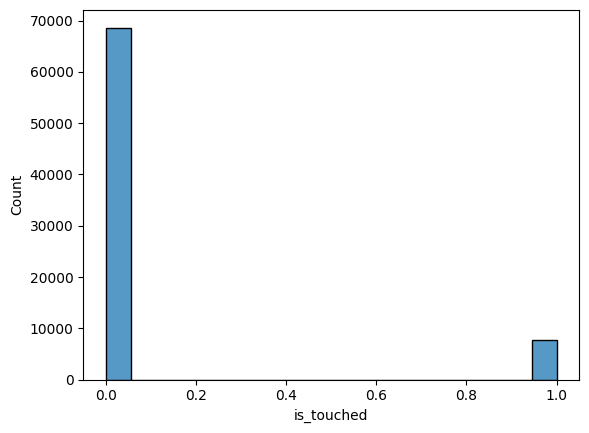

In [10]:
sns.histplot(data['is_touched'])

In [11]:
import torch
torch.cuda.is_available()

True

In [12]:
import pandas as pd
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score, accuracy_score

In [13]:
all_images = list(data['plt_dir'])

In [14]:
# import cv2

# all_shapes = []
# for img_name in all_images:
#     img = cv2.imread(img_name)
#     all_shapes.append(img.shape[:2])

In [15]:
# Размеры разные
# np.unique(all_shapes)

In [16]:
from torchvision import transforms
import functools
import matplotlib.pyplot as plt

transform_train = transforms.Compose(
    [   
        transforms.ToTensor(),
        transforms.Resize((608, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1, 0.03, 0.03, 0.01),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)


transform = transforms.Compose(
    [   
        transforms.ToTensor(),
        transforms.Resize((608, 256)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

inv_im_trans = transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225])

In [17]:
data = data.sort_values(by=['scan_result'])

In [18]:
import tqdm

deltas = []
cnt_reversed = 0
bad_palletes = []
for plts in tqdm.tqdm(sorted(set(data['scan_result']))):
    subs = data[data['scan_result'] == plts].sort_values(by=['add_date']).reset_index()
    touch_date = None
    for idx, row in subs.iterrows():
        if row['is_touched'] and touch_date is None:
            touch_date = row['add_date']
        if not row['is_touched'] and touch_date and row['add_date'] > touch_date:
            #print(touch_date, row['add_date'])
            #print(row['scan_result'])
            bad_palletes.append(row['scan_result'])
            cnt_reversed += 1
            break

100%|█████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:41<00:00, 158.94it/s]


In [19]:
data['is_noisy_label'] = 0

In [76]:
import tqdm

deltas = []
cnt_reversed = 0
bad_palletes = []
for plts in sorted(set(data['scan_result'])):
    subs = data[data['scan_result'] == plts]
    if sum(subs['is_touched']):
        touched_loc = set(subs[subs['is_touched'] == 1]['location'])
        data.loc[(data['scan_result'] == plts) & (data['is_touched'] == 0) & (~data['location'].isin(touched_loc)), 'is_noisy_label'] = 1
        data.loc[(data['scan_result'] == plts) & (data['is_touched'] == 0) & (data['location'].isin(touched_loc)), 'is_noisy_label'] = 2

In [90]:
for plts in sorted(set(data['scan_result'])):
    subs = data[data['scan_result'] == plts].sort_values(by=['add_date']).reset_index()
    if len(set(subs['is_touched'])) == 2:
        break

In [91]:
с

327

In [92]:
subs

index                   add_date  location  is_touched  \
0    2982 2022-10-27 10:25:41.996871  K21-22A2           0   
1   42648 2022-10-27 10:49:47.285845  K21-22A2           0   
2   26789 2022-10-27 11:40:40.265383  K21-22A2           0   
3   33452 2022-10-27 12:15:22.577808  K21-22A2           0   
4    4969 2022-10-27 15:07:22.802839  K21-22A2           0   
5   41056 2022-10-27 15:46:47.964063  K21-22A2           0   
6   34395 2022-10-27 16:15:21.751134  K21-22A2           0   
7    4683 2022-10-27 18:06:41.456628  K21-22A2           0   
8   17446 2022-10-28 13:13:17.833149  K21-22A2           0   
9   57519 2022-10-28 13:18:50.836873  K21-22A2           0   
10   4736 2022-10-28 14:00:11.146317  K21-22A2           0   
11  48420 2022-10-31 10:54:47.511323  K21-22A2           0   
12  14970 2022-10-31 11:27:23.514387  K21-22A2           0   
13   1304 2022-10-31 12:36:30.752580  K21-22A2           0   
14  45438 2022-11-01 16:48:11.818509  K21-22A2           0   
15  40807 2022-11-01 18:26:21.166669  K21-22A2           0   
16  16774 2022-11-02 16:26:40.172290  K21-22A2           0   
17  12514 2022-11-03 13:31:33.373312  K21-22A2           0   
18  10206 2022-11-03 15:59:23.251749  K21-22A2           0   
19  59958 2022-11-03 17:30:15.253116  K21-22A2           0   
20  21561 2022-11-07 15:35:01.523265  K21-22A2           1   
21  13607 2022-11-07 20:22:18.735078  K21-22A2           1   
22  11818 2022-11-08 13:20:07.373276  K21-22A2           1   
23  13820 2022-11-08 13:59:22.398980  K21-22A2           1   
24   9900 2022-11-08 15:14:25.143685  K21-22A2           1   
25  23199 2022-11-08 17:04:23.923927  K21-22A2           1   
26  32271 2022-11-08 17:51:20.291847  K21-22A2           1   
27  19701 2022-11-09 13:29:23.409012  K21-22A2           1   
28  74218 2022-11-10 12:32:21.531223  K21-22A2           1   
29   9062 2022-11-10 14:48:02.655765  K21-22A2           1   
30  16304 2022-11-10 15:44:21.589598  K21-22A2           1   

                                              s3_link  scan_result  \
0   https://s3.mds.yandex.net/rms-cloud/1c4dbe81-3...  PLT11133807   
1   https://s3.mds.yandex.net/rms-cloud/64001f90-3...  PLT11133807   
2   https://s3.mds.yandex.net/rms-cloud/12ccf31b-7...  PLT11133807   
3   https://s3.mds.yandex.net/rms-cloud/74176ee3-6...  PLT11133807   
4   https://s3.mds.yandex.net/rms-cloud/ffd15945-d...  PLT11133807   
5   https://s3.mds.yandex.net/rms-cloud/0b425956-9...  PLT11133807   
6   https://s3.mds.yandex.net/rms-cloud/51043869-6...  PLT11133807   
7   https://s3.mds.yandex.net/rms-cloud/0c6a0b26-8...  PLT11133807   
8   https://s3.mds.yandex.net/rms-cloud/eaba11ef-d...  PLT11133807   
9   https://s3.mds.yandex.net/rms-cloud/0a903ed2-5...  PLT11133807   
10  https://s3.mds.yandex.net/rms-cloud/82b80467-9...  PLT11133807   
11  https://s3.mds.yandex.net/rms-cloud/cdacfa1e-5...  PLT11133807   
12  https://s3.mds.yandex.net/rms-cloud/43b3b4af-8...  PLT11133807   
13  https://s3.mds.yandex.net/rms-cloud/a72be096-4...  PLT11133807   
14  https://s3.mds.yandex.net/rms-cloud/607a1112-4...  PLT11133807   
15  https://s3.mds.yandex.net/rms-cloud/0e3b6464-c...  PLT11133807   
16  https://s3.mds.yandex.net/rms-cloud/e30c2cad-b...  PLT11133807   
17  https://s3.mds.yandex.net/rms-cloud/2689749a-9...  PLT11133807   
18  https://s3.mds.yandex.net/rms-cloud/58680e0f-1...  PLT11133807   
19  https://s3.mds.yandex.net/rms-cloud/da5a0010-b...  PLT11133807   
20  https://s3.mds.yandex.net/rms-cloud/b8354ba2-5...  PLT11133807   
21  https://s3.mds.yandex.net/rms-cloud/32196008-2...  PLT11133807   
22  https://s3.mds.yandex.net/rms-cloud/2d1d68fd-e...  PLT11133807   
23  https://s3.mds.yandex.net/rms-cloud/4b5c3401-c...  PLT11133807   
24  https://s3.mds.yandex.net/rms-cloud/0f5040cb-b...  PLT11133807   
25  https://s3.mds.yandex.net/rms-cloud/bdf7f663-5...  PLT11133807   
26  https://s3.mds.yandex.net/rms-cloud/b780a65a-0...  PLT11133807   
27  https://s3.mds.yandex.net/rms-cloud/13fff39b-1...  PLT1

In [22]:
import tqdm

deltas = []
data = data.groupby('scan_result').filter(lambda x: len(x) > 1)
for plts in tqdm.tqdm(sorted(set(data['scan_result']) - set(bad_palletes))):
    subs = data[data['scan_result'] == plts].sort_values(by=['add_date']).reset_index()
    idx1 = idx2 = 0
    if len(subs['is_touched'].unique()) > 1:
        subs_0 = subs[subs['is_touched'] == 0]
        subs_1 = subs[subs['is_touched'] == 1]
        idx1 = np.random.randint(0, len(subs_0))
        idx2 = np.random.randint(0, len(subs_1))
        first_label = subs_0.iloc[idx1]['is_touched']
        second_label = subs_1.iloc[idx2]['is_touched']
    else:
        idx1 = np.random.randint(0, len(subs))
        idx2 = np.random.randint(idx1, len(subs))
        first_label = subs.iloc[idx1]['is_touched']
        second_label = subs.iloc[idx2]['is_touched']
        
#     if second_label < first_label:
#         break
    deltas.append(second_label - first_label)

100%|█████████████████████████████████████████████████████████████████████████████| 4789/4789 [00:26<00:00, 177.81it/s]


In [23]:
np.mean(deltas)

0.06828147838797244

<AxesSubplot: ylabel='Count'>

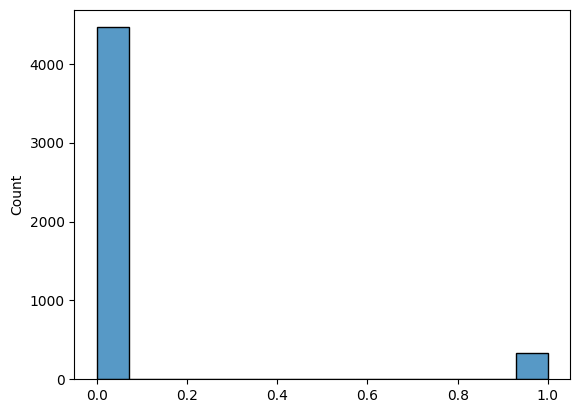

In [24]:
sns.histplot(deltas)

In [25]:
from torch.utils.data import Dataset
from skimage import io
from pyzbar.pyzbar import decode
from datetime import datetime
import random

def reseed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    
class HistoryImagesDataset(Dataset):
    def __init__(self, pallets, data, transform=None, is_valid=False):
        super().__init__()
        self.data = data
        self.pallets = pallets
        self.transform = transform
        self.is_valid = is_valid

    def __len__(self):
        return len(self.pallets)

    def __getitem__(self, idx):
        
        if self.is_valid:
            np.random.seed(idx)
        else:
            np.random.seed(int(datetime.now().timestamp()))
    
        plts = self.pallets[idx]
        subs = self.data[self.data['scan_result'] == plts].sort_values(by=['add_date']).reset_index()
        
        if len(subs['is_touched'].unique()) > 1:
            subs_0 = subs[subs['is_touched'] == 0]
            subs_1 = subs[subs['is_touched'] == 1]
            idx1 = np.random.randint(0, len(subs_0))
            idx2 = np.random.randint(0, len(subs_1))
            first_path = subs_0.iloc[idx1]['plt_dir']
            second_path = subs_1.iloc[idx2]['plt_dir']
            label = 1
        else:
            idx1 = np.random.randint(0, len(subs))
            idx2 = np.random.randint(idx1, len(subs))
            first_path = subs.iloc[idx1]['plt_dir']
            second_path = subs.iloc[idx2]['plt_dir']
            label = 0
        
        img1 = io.imread(first_path)
        img1 = img1[...,:3]
        
        img2 = io.imread(second_path)
        img2 = img2[...,:3]
        
        if self.transform:
            # Symmetrical transforms
            sequence_seed = np.random.randint(2147483647)
            reseed(sequence_seed)
            img1 = self.transform(img1)
            reseed(sequence_seed)
            img2 = self.transform(img2)

        return img1, img2, label

In [26]:
palletes = set(data['scan_result']) - set(bad_palletes)
train_dataset = HistoryImagesDataset(sorted(list(palletes)), data, transform=transform_train, is_valid=False)

In [27]:
batch = train_dataset[0]

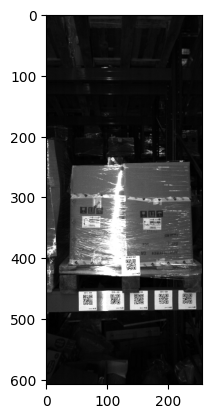

In [28]:
plt.imshow(inv_im_trans(batch[1]).permute(1, 2, 0).numpy())

In [29]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)), train_dataset.targets, 
#                                                     stratify=train_dataset.targets, test_size=0.3, random_state=1337)
# train_split = Subset(train_dataset, train_indices)
# val_split = Subset(train_dataset, val_indices)

In [30]:
pallets = sorted(set(data['scan_result']) - set(bad_palletes))
train_pallets, test_pallets = train_test_split(pallets, test_size=0.25, random_state=42)
data_train, data_test = data.loc[data['scan_result'].isin(train_pallets)], data.loc[data['scan_result'].isin(test_pallets)]

In [31]:
np.mean(data_train['is_touched'])

0.09874699497341007

In [32]:
np.mean(data_test['is_touched'])

0.11827111984282908

In [33]:
len(data_train)

54908

In [34]:
len(data_test)

17815

In [35]:
train_split = HistoryImagesDataset(sorted(train_pallets), data_train, transform=transform_train, is_valid=False)
val_split = HistoryImagesDataset(sorted(test_pallets), data_test, transform=transform_train, is_valid=True)

In [36]:
train_loader = torch.utils.data.DataLoader(train_split, 
                                           batch_size=16,
                                           num_workers=0,
                                           shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(val_split, 
                                         batch_size=32,
                                         num_workers=0,
                                         shuffle=False)

In [37]:
focal_loss = torch.hub.load(
    'adeelh/pytorch-multi-class-focal-loss',
    model='FocalLoss',
    alpha=torch.tensor([.75, .25]),
    gamma=2,
    reduction='mean',
    force_reload=False
)

Using cache found in C:\Users\andry/.cache\torch\hub\adeelh_pytorch-multi-class-focal-loss_master


In [38]:
import torch
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch import nn
from torch.nn import *
import pytorch_lightning as pl
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import timm
import torchmetrics

class ImageClassifier(pl.LightningModule):
    def __init__(self, trunk=None, class_weight=None, learning_rate=1e-4):
        super().__init__()
        self.class_weight = class_weight
        self.trunk = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.trunk.fc = nn.Identity()
        self.fc = nn.Sequential(nn.Linear(2048, 2))
        
        self.learning_rate = learning_rate
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.train_f1 = torchmetrics.F1Score(task="binary")
        self.train_auc = torchmetrics.AUROC(task="binary")
        self.train_pr = torchmetrics.AveragePrecision(task="binary")
        
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_f1 = torchmetrics.F1Score(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")
        self.val_pr = torchmetrics.AveragePrecision(task="binary")
        self.loss = focal_loss
        
    def forward(self, im1, im2):
        x1 = self.trunk(im1)
        x2 = self.trunk(im2)
        diff = x2 - x1
        x = self.fc(diff)
        return x

    def predict_proba(self, im1, im2):
        probabilities = nn.functional.softmax(self.forward(im1, im2), dim=1)
        return probabilities
    
    def predict(self, im1, im2):
        return torch.max(self.forward(im1, im2), 1)[1]

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        im1, im2, y = batch
        y_hat = self(im1, im2)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        
        y_hat = nn.functional.softmax(y_hat, dim=1)[:, 1]
        self.train_accuracy.update(y_hat, y)
        self.log('train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        self.train_f1.update(y_hat, y)
        self.log('train_f1', self.train_f1, on_step=False, on_epoch=True)
        self.train_auc.update(y_hat, y)
        self.log('train_auc', self.train_auc, on_step=False, on_epoch=True)
        self.train_pr.update(y_hat, y)
        self.log('train_pr', self.train_pr, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        im1, im2, y = batch
        y_hat = self(im1, im2)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss)
        
        y_hat = nn.functional.softmax(y_hat, dim=1)[:, 1]
        self.val_accuracy.update(y_hat, y)
        self.log('val_acc', self.val_accuracy, on_step=False, on_epoch=True)
        self.val_f1.update(y_hat, y)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True)
        self.val_auc.update(y_hat, y)
        self.log('val_auc', self.val_auc, on_step=False, on_epoch=True)
        self.val_pr.update(y_hat, y)
        self.log('val_pr', self.val_pr, on_step=False, on_epoch=True)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

tb_logger = pl_loggers.TensorBoardLogger(save_dir="C:/Users/andry/Desktop/MarketPrj/lightning_logs/", 
                                         version='differences focal 12.12')
model = ImageClassifier(learning_rate=3e-5)
checkpoint_callback = ModelCheckpoint(dirpath="./saves", save_top_k=2, monitor="val_pr", mode="max")
trainer = pl.Trainer(
    precision=16,
    logger=tb_logger,
    callbacks=[checkpoint_callback],
    max_epochs=1000,
    log_every_n_steps=-1,
    accelerator='gpu'
)
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint("model_resnet50_aug_new_data.ckpt")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Checkpoint directory C:\Users\andry\Desktop\MarketPrj\saves exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type                   | Params
-----------------------------------------------------------
0  | trunk          | ResNet                 | 23.5 M
1  | fc             | Sequential             | 4.1 K 
2  | train_accuracy | BinaryAccuracy         | 0     
3  | train_f1       | BinaryF1Score          | 0     
4  | train_auc      | BinaryAUROC            | 0     
5  | train_pr       | BinaryAveragePrecision | 0     
6  | val_accuracy   | BinaryAccuracy         | 0     
7  | val_f1         | BinaryF1Score          | 0     
8  | val_auc        | BinaryAUROC            | 0     
9  | val_pr         | BinaryAveragePrecision | 0     
10 | loss      

Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [42]:
import torch
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch import nn
from torch.nn import *
import pytorch_lightning as pl
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import timm
import torchmetrics

class ImageClassifier(nn.Module):
    def __init__(self, trunk=None, class_weight=None, learning_rate=1e-4):
        super().__init__()
        self.class_weight = class_weight
        self.trunk = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.trunk.fc = nn.Identity()
        self.fc = nn.Sequential(nn.Linear(2048, 2))
        self.loss = focal_loss
        
    def forward(self, im1, im2):
        x1 = self.trunk(im1)
        x2 = self.trunk(im2)
        diff = x2 - x1
        x = self.fc(diff)
        return x

    def predict_proba(self, im1, im2):
        probabilities = nn.functional.softmax(self.forward(im1, im2), dim=1)
        return probabilities
    
    def predict(self, im1, im2):
        return torch.max(self.forward(im1, im2), 1)[1]

In [43]:
model = ImageClassifier(learning_rate=1e-4)

In [47]:
model.load_state_dict(torch.load('./saves/epoch=66-step=15008.ckpt')['state_dict'])
model.eval()
model = model.cuda()

In [51]:
import tqdm.auto as tqdm

def evaluate_model_val(model, loader):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for x1, x2, y in tqdm.tqdm(loader):
            prediction = model.predict_proba(x1.to('cuda'), x2.to('cuda')).cpu().numpy()
            predictions += list(prediction)
            labels += list(y.numpy())
    return labels, predictions

In [52]:
val_loader = torch.utils.data.DataLoader(val_split, batch_size=32, num_workers=0, shuffle=False)
labels, predictions = evaluate_model_val(model, val_loader)

  0%|          | 0/38 [00:00<?, ?it/s]

In [53]:
conf = np.array(predictions)[:, 1]

In [54]:
#preds = np.zeros_like(conf)
preds = conf.copy()

In [93]:
labels = np.array(labels)

auc=0.195


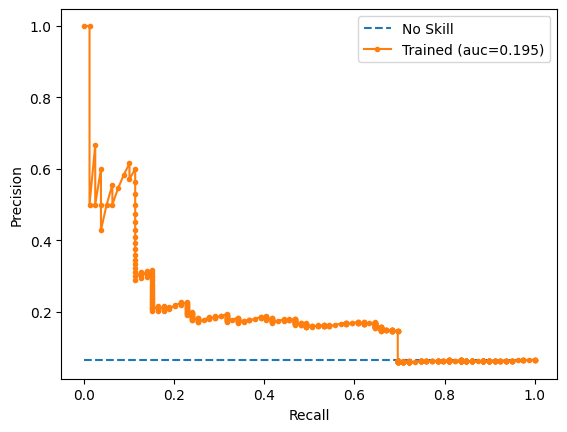

In [95]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(labels, conf)
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('auc=%.3f' % (lr_auc))
# plot the precision-recall curves
no_skill = len(labels[labels==1]) / len(labels)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Trained (auc=0.195)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
pyplot.savefig('./diff.png', dpi=300)
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.647


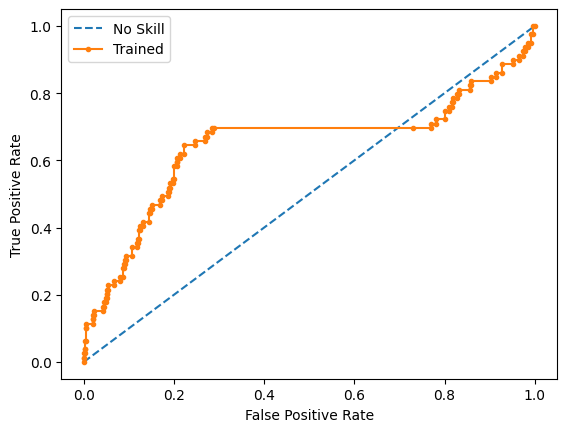

In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# calculate scores
ns_probs = [0 for _ in range(len(labels))]
ns_auc = roc_auc_score(labels, ns_probs)
lr_auc = roc_auc_score(labels, conf)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(labels, conf)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Trained')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()